In [1]:
# On importe les bibliothèques utiles pour le projet
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import functools
import os
import cv2
import glob
# Les functions écrites dans un fichier externe
from functions import *
from collections import namedtuple

from keras_segmentation.models.unet import vgg_unet, resnet50_unet
from keras_segmentation.models.fcn import fcn_8_vgg, fcn_8_resnet50, fcn_32_resnet50
from keras_segmentation.models.segnet import vgg_segnet, resnet50_segnet
from keras import backend as K
from keras.utils import Sequence, to_categorical
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import keras.utils as image
#from keras.utils import multi_gpu_model
from dilatednet import DilatedNet
from models import vgg16unet, build_vgg16_unet

In [2]:
tf.__version__

'2.10.0'

In [3]:
keras.__version__

'2.10.0'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

Num GPUs Available: 1


In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
#    try:
#        for gpu in gpus:
#            tf.config.experimental.set_virtual_device_configuration(
#                gpu,
#                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])  # Définissez la limite en fonction de vos besoins
#    except RuntimeError as e:
#        print(e)
        
#tf.compat.v1.disable_eager_execution()

## Modification des images (Nom + suppression de certain masks) + normalisation de pixels
* Travailler uniquement les jeux de Train et Validation pour pouvoir entraîner et évaluer les modèles (capacité à prédire correctement) (Les masks de tests ne sont pas utilisable);
* Garder le set Validation pour en faire un set de Test ;
* Créer un nouveau set de Validation en faisant un split sur le set Train : 80% pour l'entraînement, 20% pour la validation.

### Définition des sous catégories

In [9]:
# Adaptation from the official Cityscapes scripts
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#--------------------------------------------------------------------------------
# Definitions : 
#--------------------------------------------------------------------------------
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

In [8]:
# Nettoyage et préparation des images d'entraînement
chemin_source_images_train = 'datas/images/train/'
chemin_nouveau_dossier_images_train = 'datas/images/train_clean'

regroupement_renommage_datas(chemin_source_images_train, chemin_nouveau_dossier_images_train, type="images")

KeyboardInterrupt: 

In [ ]:
# Nettoyage et préparation des masks d'entraînement
chemin_source_masks_train = 'datas/masks/train/'
chemin_nouveau_dossier_masks_train = 'datas/masks/train_clean'

regroupement_renommage_datas(chemin_source_masks_train, chemin_nouveau_dossier_masks_train, type="masks")

In [ ]:
# Nettoyage et préparation des images de validation
chemin_source_images_val = 'datas/images/val/'
chemin_nouveau_dossier_images_val = 'datas/images/val_clean'

regroupement_renommage_datas(chemin_source_images_val, chemin_nouveau_dossier_images_val, type="images")

In [ ]:
# Nettoyage et préparation des masks de validation
chemin_source_masks_val = 'datas/masks/val/'
chemin_nouveau_dossier_masks_val = 'datas/masks/val_clean'

regroupement_renommage_datas(chemin_source_masks_val, chemin_nouveau_dossier_masks_val, type="masks")

In [ ]:
# Nettoyage et préparation des images de test
chemin_source_images_test = 'datas/images/test/'
chemin_nouveau_dossier_images_test = 'datas/images/test_clean'

regroupement_renommage_datas(chemin_source_images_test, chemin_nouveau_dossier_images_test, type="images")

In [ ]:
# Nettoyage et préparation des masks de test
chemin_source_masks_test = 'datas/masks/test/'
chemin_nouveau_dossier_masks_test = 'datas/masks/test_clean'

regroupement_renommage_datas(chemin_source_masks_test, chemin_nouveau_dossier_masks_test, type="masks")

In [10]:
# Set origin folders
train_image_dir = 'datas/images/train'
train_mask_dir = 'datas/masks/train'
val_image_dir = 'datas/images/val'
val_mask_dir = 'datas/masks/val'
test_image_dir = 'datas/images/test'
test_mask_dir = 'datas/masks/test'

# Set final destination folders
train_input_dir = 'datas/images/train_clean'
train_masks30_dir = 'datas/masks/train_clean'
test_input_dir = 'datas/images/test_clean'
test_masks30_dir = 'datas/masks/test_clean'
val_input_dir = 'datas/images/val_clean'
val_masks30_dir = 'datas/masks/val_clean'

# Set masks folders with 8 main categories
train_target_dir = 'datas/masks/train_clean_normalized'
val_target_dir = 'datas/masks/val_clean_normalized'
test_target_dir = 'datas/masks/test_clean_normalized'

In [ ]:
# Save the masks for TRAIN
old_to_new_mask(train_input_dir, train_masks30_dir, train_target_dir, labels)

# Save the masks for VAL
old_to_new_mask(val_input_dir, val_masks30_dir, val_target_dir, labels)

# Save the masks for TEST
old_to_new_mask(test_input_dir, test_masks30_dir, test_target_dir, labels)

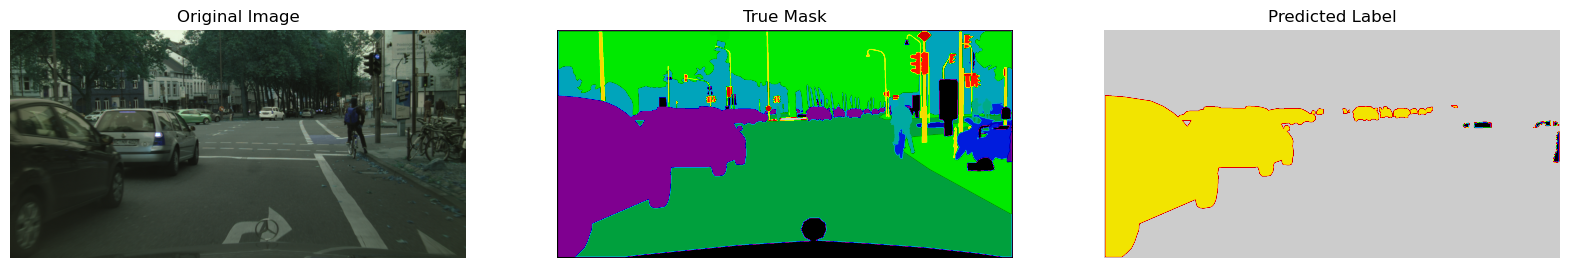

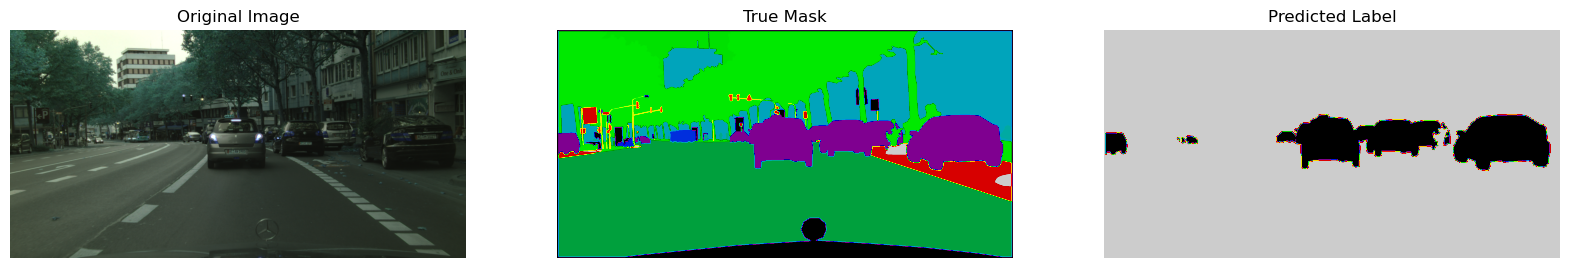

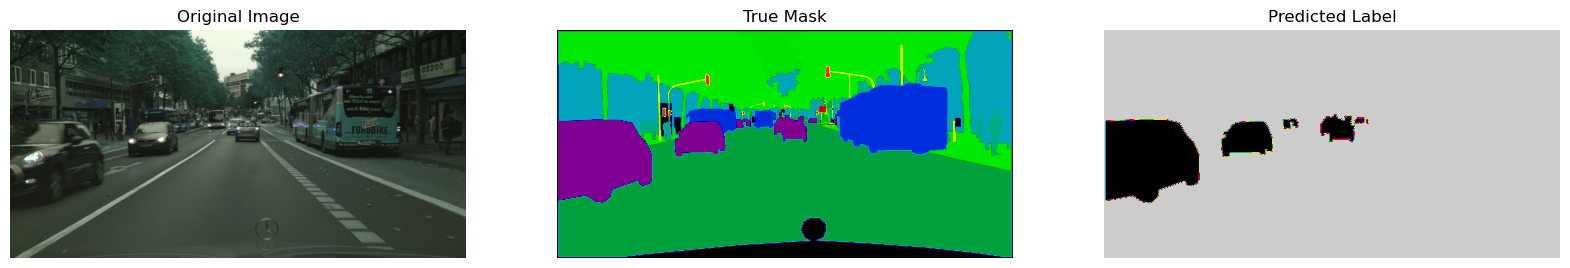

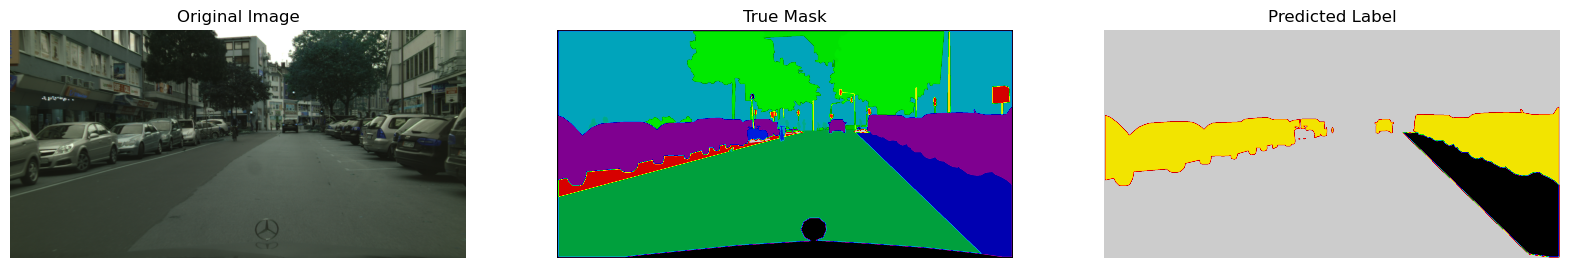

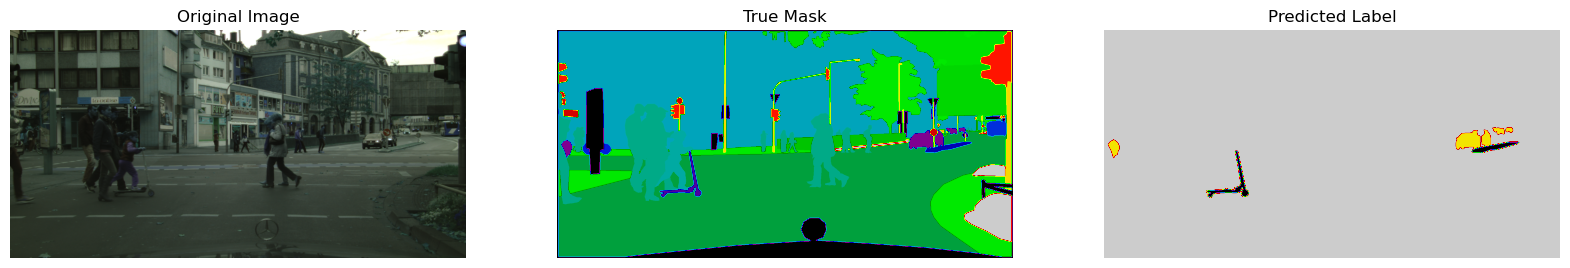

In [11]:
# Call the function
visualize_img_msk30_msk8(train_input_dir, train_masks30_dir,
                         train_target_dir, n=10)

In [ ]:
# Normalisation des masks d'entrainement (Pour les models keras_segmentation)
chemin_source_masks_train = 'datas/masks/train_clean'
chemin_masks_train_normalized = 'datas/masks/train_clean_normalized'

normalisation_mask(chemin_source_masks_train, chemin_masks_train_normalized)

In [ ]:
# Normalisation des masks de validation (Pour les models keras_segmentation)
chemin_source_masks_val = 'datas/masks/val_clean'
chemin_masks_val_normalized = 'datas/masks/val_clean_normalized'

normalisation_mask(chemin_source_masks_val, chemin_masks_val_normalized)

# Importation des images (Train/Validation/Test)

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

In [ ]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [ ]:
# Importation du jeu d'entraînement
image_train_dir = 'datas/images/train_clean'
mask_train_dir = 'datas/masks/train_clean'
image_train_list = os.listdir(image_train_dir)
mask_train_list = os.listdir(mask_train_dir)
image_train_list.sort()
mask_train_list.sort()

print(f'. . . . .Number of images: {len(image_train_list)}\n. . . . .Number of masks: {len(mask_train_list)}')

In [ ]:
image_train_list[1]

In [ ]:
mask_train_list[1]

In [ ]:
# sanity check jeu d'entraînement
for i in range(len(image_train_list)):
    assert image_train_list[1] == mask_train_list[1]

In [ ]:
i = 1
test_image = image.img_to_array(image.load_img(f'{image_train_dir}/{image_train_list[i]}'))/255.
test_mask = image.img_to_array(image.load_img(f'{mask_train_dir}/{mask_train_list[i]}', grayscale=True))
test_mask = np.squeeze(test_mask)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('GT_Mask')
ax1.imshow(test_mask)

In [ ]:
# Importation du jeu de validation
image_val_dir = 'datas/images/val_clean'
mask_val_dir = 'datas/masks/val_clean'
image_val_list = os.listdir(image_val_dir)
mask_val_list = os.listdir(mask_val_dir)
image_val_list.sort()
mask_val_list.sort()

print(f'. . . . .Number of images: {len(image_val_list)}\n. . . . .Number of masks: {len(mask_val_list)}')

# sanity check jeu de validation
for i in range(len(image_val_list)):
    assert image_val_list[i] == mask_val_list[i]

In [ ]:
# Importation du jeu de test
image_test_dir = 'datas/images/test_clean'
mask_tes_dir = 'datas/masks/test_clean'
image_test_list = os.listdir(image_test_dir)
mask_test_list = os.listdir(mask_tes_dir)
image_test_list.sort()
mask_test_list.sort()

print(f'. . . . .Number of images: {len(image_test_list)}\n. . . . .Number of masks: {len(mask_test_list)}')

# sanity check jeu de validation
for i in range(len(image_test_list)):
    assert image_test_list[i] == mask_test_list[i]

# Test nouveau data generator

In [ ]:
# Set all paths to folders: project, model, images, masks
train_input_dir = 'datas/images/train_clean'
train_mask_dir = 'datas/masks/train_clean'
val_input_dir = 'datas/images/val_clean'
val_mask_dir = 'datas/mask/val_clean'
test_input_dir = 'datas/images/test_clean'
test_mask_dir = 'datas/masks/test_clean'

In [ ]:
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_mask_path = sorted(glob.glob(train_mask_dir +'/*.png'))
print('TRAIN -- Number of images: ', len(train_input_path), 
      ' - Number of original masks: ', len(train_mask_path))
print(train_input_path[0] + '\n')

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_mask_path = sorted(glob.glob(val_mask_dir +'/*.png'))
print('VAL -- Number of images: ', len(val_input_path), 
      ' - Number of original masks: ', len(val_mask_path))
print(val_input_path[0] + '\n')

test_input_path = sorted(glob.glob(test_input_dir + '/*.png'))
test_mask_path = sorted(glob.glob(test_mask_dir +'/*.png'))
print('TEST -- Number of images: ', len(test_input_path), 
      ' - Number of original masks: ', len(test_mask_path))
print(test_input_path[0])

In [ ]:
train_mask_path

In [ ]:
# Set parameters & hyperparameters
img_height, img_width = 256, 256
img_size = (img_height, img_width)
batch_size = 8
n_classes = 8
samples = 50000

In [ ]:
from collections import namedtuple

# Adaptation from the official Cityscapes scripts
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#--------------------------------------------------------------------------------
# Definitions : 
#--------------------------------------------------------------------------------
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

# Function to map labels and categories
def map_id2category(labels):
    """ This function maps the ~30 labels' IDs
        to the 8 main categories' IDs
    """
    cat_label = {label.id: label.categoryId for label in labels}
    print(cat_label)
    
    # Get the mapping
    map_category = np.vectorize(lambda k: cat_label.get(k, -1))
    return map_category

In [ ]:
class DataGenerator(Sequence):
    """Generate data for Keras
    """

    # ==== Initialize the class ==== #
    def __init__(self, input_path, target_path, img_size, batch_size, 
                 labels, n_classes, shuffle):
        self.input_path = input_path
        self.target_path = target_path
        self.targetSize = img_size
        self.batch_size = batch_size
        self.labels = labels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()


    # ==== Set the number of batches per epoch ==== #
    def __len__(self):
        return int(np.floor(len(self.input_path) / float(self.batch_size)))
    
    
    # ==== Call a method at the end of each epoch ==== #
    def on_epoch_end(self):
        # [0,1,2,3,4... nb_image]
        self.indexes = np.arange(len(self.input_path))
        
        # [2,4,1,3,0... nb_image]
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    
    # ==== Get batches of images & masks ==== #
    def __getitem__(self, index):
       # Genere batch_size nombre d'ID de row de DATA (batch_size=2, [0,1])
       currentBatchIdsRow = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    
       batch_x, batch_y = [], []
    
       # Iterate over indexes
       for i, rowId in enumerate(currentBatchIdsRow):
           # Load image, set target size, convert to array, normalize
           image = img_to_array(
               load_img(f'{self.input_path[i]}', 
                        target_size=self.targetSize))/255.
           batch_x.append(image)

           # Load original mask, set target size and convert to array
           mask30 = img_to_array(
               load_img(f'{self.target_path[i]}', color_mode = "grayscale", 
                        target_size=self.targetSize))
           non_none_mask = np.where(mask30 != None, mask30, 0)  # Filtrer les éléments None
           mask_test = non_none_mask.astype("uint8")
           
           # Map the 30 classes to 8 main categories
           map_category = map_id2category(self.labels)
           if mask_test is not None:
             mask = map_category(mask_test)
           else:
             mask = np.zeros((img_height, img_width))
        
           mask = to_categorical(mask, self.n_classes)                   
           batch_y.append(mask)
     
       return np.array(batch_x), np.array(batch_y)

In [ ]:
train_mask_path[0]

In [ ]:
# Generate data
trainGen = DataGenerator(train_input_path, train_mask_path, img_size, 
                         batch_size, labels, n_classes, shuffle=False)
#valGen = DataGenerator(val_input_path, val_mask_path, img_size, 
                       #batch_size, labels, n_classes, shuffle=False)

# Check data shape
X_train, y_train = trainGen.__getitem__(0)
print('Train shapes (X and y): ', X_train.shape, y_train.shape)
#X_val, y_val = valGen.__getitem__(0)
#print('Val shapes (X and y): ', X_val.shape, y_val.shape)

In [ ]:
plt.imshow(tf.keras.utils.array_to_img(X_train[0]))

In [ ]:
colors = [
    [255, 0, 0],      # Rouge
    [0, 255, 0],      # Vert
    [0, 0, 255],      # Bleu
    [255, 255, 0],    # Jaune
    [255, 0, 255],    # Magenta
    [0, 255, 255],    # Cyan
    [128, 128, 128],  # Gris
    [255, 255, 255]   # Blanc
]

In [ ]:
image_mask_X = X_train[0]
image_mask_X.shape

In [ ]:
for i in range(y_train[0].shape[-1]):
    c = colors[i]
    mi = y_train[0][:,:,i]==1
    image_mask_X[mi] = c

In [ ]:
image_mask_X.shape

In [ ]:
plt.imshow(tf.keras.utils.array_to_img(image_mask_X))

In [ ]:
batch_size = 16
samples = 50000
steps = samples//batch_size
img_height, img_width = 128, 128
classes = 8
filters_n = 64

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentation):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentation = augmentation

        # Ajoutez l'ImageDataGenerator pour la data augmentation
        if self.augmentation:
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(image_train_list), batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in idx:
            _image = image.img_to_array(image.load_img(f'{image_train_dir}/{image_train_list[i]}', target_size=(img_height, img_width)))/255.   
            img = image.img_to_array(image.load_img(f'{mask_train_dir}/{mask_train_list[i]}', grayscale=True, target_size=(img_height, img_width)))
            
            if self.augmentation:
                # Appliquez la data augmentation à l'image
                _image = self.datagen.random_transform(_image)
                # Appliquez la data augmentation au mask
                img = self.datagen.random_transform(img)
            
            labels = np.unique(img)
            if len(labels) < 3:
                idx = np.random.randint(0, len(image_train_list), batch_size-drawn)
                continue
            img = np.squeeze(img)
            mask = np.zeros((img.shape[0], img.shape[1], 8))
            for i in range(-1, 34):
                if i in cats['void']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
                elif i in cats['flat']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
                elif i in cats['construction']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
                elif i in cats['object']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
                elif i in cats['nature']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
                elif i in cats['sky']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
                elif i in cats['human']:
                    mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
                elif i in cats['vehicle']:
                    mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
            #mask = np.resize(mask,(img_height*img_width, 8))
            batch_y.append(mask)
            batch_x.append(_image)
            drawn += 1
        return np.array(batch_x), np.array(batch_y)

## Test du modèle Unet

In [ ]:
unet = DilatedNet(128, 128, 8,use_ctx_module=True, bn=True)
#p_unet = multi_gpu_model(unet, 4)
unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, 'accuracy', tf.keras.metrics.MeanIoU(num_classes=8)])
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='models-dr/pdilated.h5', monitor='acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='acc', patience=6, verbose=1)
callbacks = [tb, mc, es]
# datagenerator du jeu d'entraînement avec la data augmentation
train_gen_data_augm = DataGenerator(image_train_list, mask_train_list, batch_size, True)
# datagenerator du jeu de validation avec la data augmentation
val_gen_data_augm = DataGenerator(image_val_list, mask_val_list, batch_size, True)
# datagenerator du jeu de test avec la data augmentation
test_gen_data_augm = DataGenerator(image_test_list, mask_test_list, batch_size, True)
# datagenerator du jeu d'entraînement
train_gen = DataGenerator(image_train_list, mask_train_list, batch_size, False)
# datagenerator du jeu de validation
val_gen = DataGenerator(image_val_list, mask_val_list, batch_size, False)
# datagenerator du jeu de test
test_gen = DataGenerator(image_test_list, mask_test_list, batch_size, False)

### Test du modèle Unet basic avec la data augmentation

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
hist_unet_data_augm = unet.fit(train_gen_data_augm, validation_data=val_gen_data_augm, steps_per_epoch=steps, epochs=3, callbacks=callbacks, workers=8)
#print('Saving final weights')
#unet.save_weights('dilated_augm.h5')

In [ ]:
# Libérer la mémoire GPU à la fin de l'entraînement
# tf.keras.backend.clear_session()
#cuda.select_device(0)
#cuda.close()

In [ ]:
hist_unet_data_augm.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_unet_data_augm.history['mean_io_u']
val = hist_unet_data_augm.history['val_mean_io_u']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model UNET')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_unet_data_augm.history['loss']
val = hist_unet_data_augm.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model UNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Définir le modèle et les données de test
scores_unet_data_augm = unet.evaluate(test_gen_data_augm)
scores_unet_data_augm

In [ ]:
# On initialise le tableau comparatif
tab_compare = []
# Insertion du score d'évaluation pour le modèle unet avec la data augmentation
tab_compare.append(['Unet data augmentation',scores_unet_data_augm[4], hist_unet_data_augm.history['mean_io_u']])

In [ ]:
tab_compare = []

### Test du modèle Unet basic sans la data augmentation

In [ ]:
hist_unet = unet.fit(train_gen, validation_data=val_gen, steps_per_epoch=steps, epochs=3, callbacks=callbacks, workers=8)
#print('Saving final weights')
#unet.save_weights('dilated.h5')

In [ ]:
hist_unet.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_unet_data_augm.history['mean_io_u_1']
val = hist_unet_data_augm.history['val_mean_io_u_1']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model UNET')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_unet_data_augm.history['loss']
val = hist_unet_data_augm.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model UNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
scores_unet = unet.evaluate(test_gen, batch_size=32)
scores_unet

In [ ]:
# Insertion du score d'évaluation pour le modèle unet sans la data augmentation
tab_compare.append(['Unet',scores_unet[4], hist_unet.history['mean_io_u_1']])

## Test des modèles VGG16

### Test du modèle créé à partir du modèle pré-entrainé vgg16_U-Net

In [ ]:
batch_size = 8
samples = 50000
steps = samples//batch_size
img_height, img_width = 256, 256
classes = 8

In [ ]:
class DataGeneratorV2(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentation):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentation = augmentation
        
        # Ajoutez l'ImageDataGenerator pour la data augmentation
        if self.augmentation:
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        random_indexes = np.random.randint(0, len(image_train_list), self.batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in random_indexes:
            _image = image.img_to_array(image.load_img(f'{image_train_dir}/{image_train_list[i]}', target_size=(img_height, img_width)))/255.   
            img = image.img_to_array(image.load_img(f'{mask_train_dir}/{mask_train_list[i]}', grayscale=True, target_size=(img_height, img_width)))
            # Changer img par mask
            
            if self.augmentation:
                # Appliquez la data augmentation à l'image
                _image = self.datagen.random_transform(_image)
                # Appliquez la data augmentation au mask
                img = self.datagen.random_transform(img)
            
            labels = np.unique(img)
            if len(labels) < 3:
                random_indexes = np.random.randint(0, len(image_train_list), self.batch_size-drawn)
                continue
            img = np.squeeze(img)
            mask = np.zeros((img.shape[0], img.shape[1], 8))
            for label in range(-1, 34):
                if label in cats['void']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0], (img==label))
                elif label in cats['flat']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1], (img==label))
                elif label in cats['construction']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2], (img==label))
                elif label in cats['object']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3], (img==label))
                elif label in cats['nature']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4], (img==label))
                elif label in cats['sky']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5], (img==label))
                elif label in cats['human']:
                    mask[:,:,6] = np.logical_or(mask[:,:,6], (img==label))
                elif label in cats['vehicle']:
                    mask[:,:,7] = np.logical_or(mask[:,:,7], (img==label))
            
            mask = np.expand_dims(mask, axis=0)
            batch_y.append(mask)
            batch_x.append(_image)
            drawn += 1
        
        # Empilez les tableaux dans le batch
        batch_x = np.stack(batch_x, axis=0)
        batch_y = np.concatenate(batch_y, axis=0)
        
        return batch_x, batch_y

In [ ]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='models-dr/pdilated.h5', monitor='acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='acc', patience=6, verbose=1)
#vis = visualize()
callbacks = [tb, mc, es]
# datagenerator des jeux de données avec data augmentation
train_gen_vgg16_dm = DataGeneratorV2(image_train_list, mask_train_list, batch_size, True)
val_gen_vgg16_dm = DataGeneratorV2(image_val_list, mask_val_list, batch_size, True)
test_gen_vgg16_dm = DataGeneratorV2(image_test_list, mask_test_list, batch_size, True)

# datagenerator des jeux de données sans data augmentation
train_gen_vgg16 = DataGeneratorV2(image_train_list, mask_train_list, batch_size, False)
val_gen_vgg16 = DataGeneratorV2(image_val_list, mask_val_list, batch_size, False)
test_gen_vgg16 = DataGeneratorV2(image_test_list, mask_test_list, batch_size, False)

In [ ]:
train_test = DataGeneratorV2(image_train_list, mask_train_list, batch_size, False)

In [ ]:
batch_x,batch_y = train_test.__getitem__(0)

In [ ]:
batch_x.shape

In [ ]:
batch_y.shape

In [ ]:
plt.imshow(tf.keras.utils.array_to_img(batch_x[0]))

In [ ]:
batch_y[0].shape

In [ ]:
colors = [
    [255, 0, 0],      # Rouge
    [0, 255, 0],      # Vert
    [0, 0, 255],      # Bleu
    [255, 255, 0],    # Jaune
    [255, 0, 255],    # Magenta
    [0, 255, 255],    # Cyan
    [128, 128, 128],  # Gris
    [255, 255, 255]   # Blanc
]

In [ ]:
image_mask = batch_x[0]
image_mask.shape

In [ ]:
for i in range(batch_y[0].shape[-1]):
    c = colors[i]
    mi = batch_y[0][:,:,i]==1
    image_mask[mi] = c

In [ ]:
image_mask.shape

In [ ]:
def createmask(mask) :
    mask_i = tf.argmax(mask, axis=-1)
    return mask_i[0]

In [ ]:
mask = createmask(batch_y[0])
mask.shape

In [ ]:
plt.imshow(tf.keras.utils.array_to_img(image_mask))

### Test du modèle avec data augmentation

In [ ]:
input_shape = (256, 256, 3)
build_vgg16_dm = build_vgg16_unet(input_shape)
build_vgg16_dm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, 'accuracy', tf.keras.metrics.MeanIoU(num_classes=8)])

In [ ]:
hist_build_vgg16_dm = build_vgg16_dm.fit(train_gen_vgg16_dm, validation_data=val_gen_vgg16_dm, steps_per_epoch=steps, epochs=3, callbacks=callbacks, workers=8)

In [ ]:
hist_build_vgg16_dm.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_build_vgg16_dm.history['mean_io_u']
val = hist_build_vgg16_dm.history['val_mean_io_u']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model UNET')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_build_vgg16_dm.history['loss']
val = hist_build_vgg16_dm.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model UNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
scores_vgg16_unet_dm = build_vgg16_dm.evaluate(test_gen_vgg16_dm)
scores_vgg16_unet_dm

In [ ]:
# Insertion du score d'évaluation pour le modèle VGG16
tab_compare.append(['VGG16 Unet Data augmentation',scores_vgg16_unet_dm[3], hist_build_vgg16_dm.history['mean_io_u'], hist_build_vgg16_dm.history['loss']])

### Test du modèle sans data augmentation

In [ ]:
hist_build_vgg16 = build_vgg16.fit(train_gen_vgg16, validation_data=val_gen_vgg16, steps_per_epoch=steps, epochs=3, callbacks=callbacks, workers=8)

In [ ]:
hist_build_vgg16.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_build_vgg16.history['mean_io_u']
val = hist_build_vgg16.history['val_mean_io_u']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model UNET')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_build_vgg16.history['loss']
val = hist_build_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model UNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
scores_vgg16_unet = build_vgg16.evaluate(test_gen_vgg16)
scores_vgg16_unet

In [ ]:
# Insertion du score d'évaluation pour le modèle VGG16
tab_compare.append(['VGG16 Unet',scores_vgg16_unet[3], hist_build_vgg16.history['mean_io_u'], hist_build_vgg16.history['loss']])

### Test du modèle VGG16_U-Net du projet image-segmentation-keras

In [ ]:
vgg_unet = vgg_unet(n_classes=8 , input_height=256, input_width=256)

In [ ]:
hist_vgg_unet = vgg_unet.train(
    train_images =  "datas/images/train_clean",
    train_annotations = "datas/masks/train_clean_normalized",
    n_classes=8,
    val_images="datas/images/val_clean",
    val_annotations="datas/masks/val_clean_normalized",
    validate=True,
    do_augment=True, # enable augmentation
    checkpoints_path = "tmp/vgg_unet_1" , epochs=5
)

In [ ]:
hist_vgg_unet.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_vgg_unet.history['mean_io_u']
val = hist_vgg_unet.history['val_mean_io_u']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model VGG16 UNET')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_vgg_unet.history['loss']
val = hist_vgg_unet.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model VGG16 UNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
score_vgg_unet = vgg_unet.evaluate_segmentation(inp_images_dir="datas/images/test_clean"  , annotations_dir="datas/masks/test_clean")
score_vgg_unet

In [ ]:
# Insertion du score d'évaluation pour le modèle VGG16 image-segmentation-keras
tab_compare.append(['VGG16 Unet image-segmentation',score_vgg_unet['mean_IU'], hist_vgg_unet.history['mean_io_u'], hist_vgg_unet.history['loss']])

### Test du modèle VGG16_fcn du projet image-segmentation-keras

In [ ]:
vgg_fcn = fcn_8_vgg(n_classes=8 , input_height=256, input_width=256)

In [ ]:
hist_vgg_fcn = vgg_fcn.train(
    train_images =  "datas/images/train_clean",
    train_annotations = "datas/masks/train_clean_normalized",
    n_classes=8,
    val_images="datas/images/val_clean",
    val_annotations="datas/masks/val_clean_normalized",
    validate=True,
    do_augment=True, # enable augmentation
    checkpoints_path = "tmp/vgg_fcn_1" , epochs=5
)

In [ ]:
hist_vgg_fcn.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_vgg_fcn.history['mean_io_u_1']
val = hist_vgg_fcn.history['val_mean_io_u_1']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model VGG16 fcn')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_vgg_fcn.history['loss']
val = hist_vgg_fcn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model VGG16 fcn')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
score_vgg_fcn = vgg_fcn.evaluate_segmentation( inp_images_dir="datas/images/test_clean"  , annotations_dir="datas/masks/test_clean" )
score_vgg_fcn

In [ ]:
# Insertion du score d'évaluation pour le modèle VGG16 FCN
tab_compare.append(['VGG16 FCN',score_vgg_fcn['mean_IU'], hist_vgg_fcn.history['mean_io_u_1'], hist_vgg_fcn.history['loss']])

### Test du modèle VGG16_Seg-Net du projet image-segmentation-keras

In [ ]:
vgg_segnet = vgg_segnet(n_classes=8 , input_height=256, input_width=256)

In [ ]:
hist_vgg_segnet = vgg_segnet.train(
    train_images =  "datas/images/train_clean",
    train_annotations = "datas/masks/train_clean_normalized",
    n_classes=8,
    val_images="datas/images/val_clean",
    val_annotations="datas/masks/val_clean_normalized",
    validate=True,
    do_augment=True, # enable augmentation
    checkpoints_path = "tmp/vgg_segnet_1" , epochs=5
)

In [ ]:
hist_vgg_segnet.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_vgg_segnet.history['mean_io_u_2']
val = hist_vgg_segnet.history['val_mean_io_u_2']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model VGG16 Seg-Net')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_vgg_segnet.history['loss']
val = hist_vgg_segnet.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model VGG16 Seg-Net')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
score_vgg_segnet = vgg_segnet.evaluate_segmentation( inp_images_dir="datas/images/test_clean"  , annotations_dir="datas/masks/test_clean" )
score_vgg_segnet

In [ ]:
# Insertion du score d'évaluation pour le modèle VGG16 Segnet
tab_compare.append(['VGG16 Segnet',score_vgg_segnet['mean_IU'], hist_vgg_segnet.history['mean_io_u_2'], hist_vgg_segnet.history['loss']])

## Test des model resnet50

### Test du modèle resnet50_U-Net du projet image-segmentation-keras

In [ ]:
resnet50_unet = resnet50_unet(n_classes=8 , input_height=256, input_width=256)

In [ ]:
hist_resnet50_unet = resnet50_unet.train(
    train_images =  "datas/images/train_clean",
    train_annotations = "datas/masks/train_clean_normalized",
    n_classes=8,
    val_images="datas/images/val_clean",
    val_annotations="datas/masks/val_clean_normalized",
    validate=True,
    do_augment=True, # enable augmentation
    checkpoints_path = "tmp/resnet50_unet_1" , epochs=5
)

In [ ]:
hist_resnet50_unet.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_resnet50_unet.history['mean_io_u_3']
val = hist_resnet50_unet.history['val_mean_io_u_3']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model resnet50 UNET')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_resnet50_unet.history['loss']
val = hist_resnet50_unet.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model resnet50 UNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
score_resnet50_unet = resnet50_unet.evaluate_segmentation( inp_images_dir="datas/images/test_clean"  , annotations_dir="datas/masks/test_clean" )
score_resnet50_unet

In [ ]:
# Insertion du score d'évaluation pour le modèle Resnet50 Unet
tab_compare.append(['Resnet50 Unet',score_resnet50_unet['mean_IU'], hist_resnet50_unet.history['mean_io_u_3'], hist_resnet50_unet.history['loss']])

### Test du modèle resnet50_Seg-Net du projet image-segmentation-keras

In [ ]:
resnet50_segnet = resnet50_segnet(n_classes=8 , input_height=256, input_width=256)

In [ ]:
hist_resnet50_segnet = resnet50_segnet.train(
    train_images =  "datas/images/train_clean",
    train_annotations = "datas/masks/train_clean_normalized",
    n_classes=8,
    val_images="datas/images/val_clean",
    val_annotations="datas/masks/val_clean_normalized",
    validate=True,
    do_augment=True, # enable augmentation
    checkpoints_path = "tmp/resnet50_segnet_1" , epochs=5
)

In [ ]:
hist_resnet50_segnet.history

In [ ]:
# Affichage des courbes pour la précision d’entraînement et pour la précision de validation
sns.set()
acc = hist_resnet50_segnet.history['mean_io_u_4']
val = hist_resnet50_segnet.history['val_mean_io_u_4']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training IOU')
plt.plot(epochs, val, ':', label='Validation IOU')
plt.title('Training and Validation IOU model resnet50 Seg-Net')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
# Affichage des courbes pour la la perte d’entraînement et pour la perte de validation 
sns.set()
acc = hist_resnet50_segnet.history['loss']
val = hist_resnet50_segnet.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training loss')
plt.plot(epochs, val, ':', label='Validation loss')
plt.title('Training and Validation Loss model resnet50 Seg-Net')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.plot()

In [ ]:
score_resnet50_segnet = resnet50_segnet.evaluate_segmentation( inp_images_dir="datas/images/test_clean"  , annotations_dir="datas/masks/test_clean" )
score_resnet50_segnet

In [ ]:
# Insertion du score d'évaluation pour le modèle Resnet50 Segnet
tab_compare.append(['Resnet50 Segnet',score_resnet50_segnet['mean_IU'], hist_resnet50_segnet.history['mean_io_u_4'], hist_resnet50_segnet.history['loss']])

## Création du dataframe de comparaison
Dataframe qui permet de comparer les résultats de tous les modèles

In [ ]:
# On transforme tab_compare en dataframe 
df_tab_compare = pd.DataFrame(tab_compare, columns = ['Model testé', 'Score du modèle', 'history mean_io_u', 'loss'])
df_tab_compare

#### Comparaison des différents modèles
Le meilleur modèle avec le meilleur score du modèle et le mean_io_u est le modèle VGG16 Unet

In [ ]:
build_vgg16.save("best_model")

In [ ]:
vgg_unet.save("second_model")

In [ ]:
# Charger le modèle
model = tf.keras.models.load_model('best_model', custom_objects={'dice_coeff': dice_coeff})

In [ ]:
img_path = 'datas/images/test/berlin/berlin_000000_000019_leftImg8bit.png'
img = image.load_img(img_path, target_size=(256, 256)) 
# Convertir l'image en tableau NumPy et prétraiter
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour correspondre à la forme attendue par le modèle
#img_array = img_array / 255.0  # Normaliser les valeurs des pixels si nécessaire

In [ ]:
predictions = model.predict(img_array)

In [ ]:
predictions*255

In [ ]:
predictions[0][0][0]

In [ ]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [ ]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [ ]:
couleur = {'void': [0, 1, 2, 3, 4, 5, 6],
             'flat': [7, 8, 9, 10],
             'construction': [11, 12, 13, 14, 15, 16],
             'object': [17, 18, 19, 20],
             'nature': [21, 22],
             'sky': [23],
             'human': [24, 25],
             'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}
couleur_id = {'void': (0),
              'flat': (1),
             'construction': (2),
             'object': (3),
             'nature': (4),
             'sky': (5),
             'human': (6),
             'vehicle': (7)}
cat_couleur = {}
for label in labels :
    category = label.category
    if category in cat_couleur :
        cat_couleur[category].append(label)
    else :
        cat_couleur[category] = label
    

In [ ]:
predictions.shape

In [ ]:
predictions = predictions.reshape(1,256,256,8)
predictions

In [ ]:
predictions.shape
prediction_image = np.squeeze(predictions*255)
prediction_image.shape

In [ ]:
seg_img = np.zeros((256,256,3),dtype=np.uint8)
for id in range(prediction_image.shape[2]) :
    couleur_seg = cat_couleur.get(id,(0,0,0))
    for j in range(3) :
        seg_img[:,:,j] += (prediction_image[:,:,id]*couleur_seg[j]).astype(np.uint8)

In [ ]:
seg_img.shape

In [ ]:
seg_img

In [ ]:
plt.imshow(seg_img)
plt.axis('off')  # Pour ne pas afficher les axes
plt.show()

In [ ]:
colors = [
    (255, 0, 0),      # Rouge
    (0, 255, 0),      # Vert
    (0, 0, 255),      # Bleu
    (255, 255, 0),    # Jaune
    (255, 0, 255),    # Magenta
    (0, 255, 255),    # Cyan
    (128, 128, 128),  # Gris
    (255, 255, 255)   # Blanc
]

In [ ]:
image_width = predictions.shape[2]
image_height = 1
image = Image.new("RGB", (image_width, image_height))

# Parcourir les valeurs de la prédiction et attribuer les couleurs correspondantes
for x, prediction_value in enumerate(predictions[0][0]):
    color_index = np.argmax(prediction_value)
    color = colors[color_index]
    image.putpixel((x, 0), color)

# Redimensionner l'image à 256x256
image_resized = image.resize((256, 256))

# Sauvegarder l'image
image_resized.save("predicted_image_resized.png")

# Afficher l'image
image_resized.show()

In [ ]:
# Affichage de l'image
plt.imshow(predictions[1], cmap='gray')
plt.axis('off')  # Désactiver les axes
plt.show()

In [ ]:
# Afficher les prédictions
print(predictions[0][1][0][3])

In [ ]:
# Convertir les prédictions en une image de couleur masquée
img_path = 'datas/images/test/berlin/berlin_000000_000019_leftImg8bit.png'
img = image.load_img(img_path, target_size=(128, 128)) 
# Convertir l'image en tableau NumPy et prétraiter
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour correspondre à la forme attendue par le modèle
img_array = img_array / 255.0  # Normaliser les valeurs des pixels si nécessaire
def label_to_color_image(label):
    label_colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Définir les couleurs des classes
    colored_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for i in range(len(label_colors)):
        colored_label[label == i] = label_colors[i]
    return colored_label
# Afficher l'image d'entrée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image d\'entrée')
plt.axis('off')

# Afficher les prédictions de segmentation
plt.subplot(1, 2, 2)
colored_predictions = label_to_color_image(np.argmax(predictions[0], axis=-1)) 
plt.imshow(colored_predictions)  # Supposons que predictions[0] contient les prédictions de segmentation
plt.title('Prédictions de segmentation')
plt.axis('off')

plt.show()

In [ ]:
# Afficher l'image d'entrée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image d\'entrée')
plt.axis('off')

# Afficher les prédictions de segmentation
plt.subplot(1, 2, 2)
colored_predictions = label_to_color_image(np.argmax(predictions[0], axis=-1)) 
plt.imshow(colored_predictions)  # Supposons que predictions[0] contient les prédictions de segmentation
plt.title('Prédictions de segmentation')
plt.axis('off')

plt.show()